# DECISION TREE 

## Import the required libraries

In [1]:
# Import libraries
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import AdaBoostClassifier

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc,RocCurveDisplay,PrecisionRecallDisplay

In [3]:
import pandas as pd
import numpy as np
import pickle

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


## Importing Helper Functions

In [8]:
# Import the helper functions
# Import the required functions from the helper function file
from helper_functions_ml import createMetricsDF,computeModelMetrics,computeAndPlotMetrics

## Import the data (training and testing)

In [10]:
# Read the training data
df_train = pd.read_csv('df.csv')
print(df_train.head())

df_train = df_train.drop('Unnamed: 0', axis=1)
df_train.head(3)

   Unnamed: 0  TransactionID  isFraud  TransactionDT  TransactionAmt  \
0           0        2987000        0          86400        1.835691   
1           1        2987001        0          86401        1.462398   
2           2        2987002        0          86469        1.770852   
3           3        2987003        0          86499        1.698970   
4           4        2987004        0          86506        1.698970   

   ProductCD  card1  card2  card3  card4  ...  id_36  id_37  id_38  \
0          4  13926   -1.0  150.0      1  ...      2      2      2   
1          4   2755  404.0  150.0      2  ...      2      2      2   
2          4   4663  490.0  150.0      4  ...      2      2      2   
3          4  18132  567.0  150.0      2  ...      2      2      2   
4          1   4497  514.0  150.0      2  ...      0      1      1   

   DeviceType  DeviceInfo  P_emaildomain_addr1_card1  card1_card2  \
0           1        1735                      63363         3655   
1       

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_36,id_37,id_38,DeviceType,DeviceInfo,P_emaildomain_addr1_card1,card1_card2,card2_addr1,card2_R_emaildomain,card1_R_emaildomain
0,2987000,0,86400,1.835691,4,13926,-1.0,150.0,1,142.0,...,2,2,2,1,1735,63363,3655,33,14,7070
1,2987001,0,86401,1.462398,4,2755,404.0,150.0,2,102.0,...,2,2,2,1,1735,36911,8484,4426,2305,16599
2,2987002,0,86469,1.770852,4,4663,490.0,150.0,4,166.0,...,2,2,2,1,1735,71571,10055,5848,2911,19628


In [11]:
# CP cannot be used to copy file here because numFolds is a variable and hence the filenames will change based on the number of folds.
# instead of using linux CP command we use SHUTIL copy 

# read the K fold train and dev indices

numFolds = 3

import shutil # file copy package. 

srcFileName = 'Classification_Products\train_dev_indices_' + str(numFolds) + '.pickle' 
train_dev_indices_file = 'train_dev_indices_' + str(numFolds) + '.pickle'
# !cp  srcFileName destFileName
shutil.copyfile(srcFileName, train_dev_indices_file)


'train_dev_indices_3.pickle'

In [12]:
# read the train dev indices file
# train_dev_indices_df = pd.read_csv(train_dev_indices_file)
# train_dev_indices_df.head()

with open(train_dev_indices_file, 'rb') as handle:
    train_dev_indices = pickle.load(handle)
train_dev_indices

{'train': [array([195756, 195757, 195758, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 590537, 590538, 590539]),
  array([     0,      1,      2, ..., 397410, 397417, 397418])],
 'dev': [array([     0,      1,      2, ..., 221151, 221172, 221182]),
  array([195756, 195757, 195758, ..., 397410, 397417, 397418]),
  array([393481, 393482, 393483, ..., 590537, 590538, 590539])]}

In [13]:
X = df_train.drop(columns = ['isFraud','TransactionID','TransactionDT'])
y = df_train['isFraud']

In [14]:
# List of categorical and numerical columns in merged dataset

## Numerical columns

num_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['float64', 'int64']:
    num_column_lst_final.append(icol)
print(f"The columns that have numerical features are: '{num_column_lst_final}'")
print(f"The number of columns that have numerical features are: '{len(num_column_lst_final)}'")

print('\n')

## Categorical Columns
cat_column_lst_final = []
for icol in X.columns:
  if X[icol].dtypes in ['object']:
    cat_column_lst_final.append(icol)
print(f"The columns that have categorical features are: '{cat_column_lst_final}'")
print(f"The number of columns that have categorical features are: '{len(cat_column_lst_final)}'")

The columns that have numerical features are: '['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C3', 'C5', 'D1', 'D3', 'D4', 'D8', 'D9', 'D10', 'D13', 'D14', 'M1', 'M2', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V4', 'V6', 'V10', 'V12', 'V14', 'V15', 'V19', 'V23', 'V25', 'V27', 'V35', 'V37', 'V39', 'V44', 'V46', 'V53', 'V55', 'V61', 'V66', 'V75', 'V77', 'V82', 'V86', 'V95', 'V98', 'V99', 'V104', 'V107', 'V108', 'V109', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V129', 'V135', 'V138', 'V139', 'V141', 'V144', 'V148', 'V161', 'V169', 'V170', 'V172', 'V173', 'V174', 'V184', 'V194', 'V208', 'V209', 'V214', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V228', 'V238', 'V240', 'V241', 'V250', 'V260', 'V270', 'V281', 'V282', 'V284', 'V286', 'V288', 'V290', 'V300', 'V305', 'V313', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_10', 'id_11'

## Decision Tree Model(s)

### Basic Decision Tree Model

In [15]:
# loop through each fold, retrieve the train and dev ids for each fold before running the basic logisitic regression model on each fold
y_pred_train = {}
y_pred_dev = {}

y_pred_train_prob = {}
y_pred_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  # preprocessor = ColumnTransformer(
  #       transformers=[('scaler', StandardScaler(), num_column_lst_final)],
  #                     remainder='passthrough'
  #                     )
  # Decision Tree Classifier does not need a scaler as the decision tree classifier just 
  # takes decisions (even after scaling the relationship between the scaled values will still be the same.)

  d_tree = DecisionTreeClassifier(random_state=1,class_weight='balanced')
  d_tree.fit(X_train,y_train)

  y_pred_train[i_fold] = d_tree.predict(X_train)
  y_pred_dev[i_fold] = d_tree.predict(X_dev)

  y_pred_train_prob[i_fold] = d_tree.predict_proba(X_train)[:,1]
  y_pred_dev_prob[i_fold] = d_tree.predict_proba(X_dev)[:,1]

### Hyper-Parameter Tuning

In [31]:
params = {'max_features': [0.02,0.05],
          'splitter':['best'],
          'max_depth':[2,3,5],
          'min_samples_leaf':[0.01,0.05,0.1,0.2]}
grid = GridSearchCV(DecisionTreeClassifier(class_weight='balanced',random_state=1), param_grid=params,cv=3,verbose=3,scoring='roc_auc')    
grid.fit(X,y)  

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.01, splitter=best;, score=0.618 total time=   1.3s
[CV 2/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.01, splitter=best;, score=0.673 total time=   1.3s
[CV 3/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.01, splitter=best;, score=0.668 total time=   1.1s
[CV 1/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.05, splitter=best;, score=0.588 total time=   1.0s
[CV 2/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.05, splitter=best;, score=0.680 total time=   1.0s
[CV 3/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.05, splitter=best;, score=0.670 total time=   1.0s
[CV 1/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.1, splitter=best;, score=0.583 total time=   0.9s
[CV 2/3] END max_depth=2, max_features=0.02, min_samples_leaf=0.1, splitter=best;, score=0.681 total time=   1.0s
[CV 3/3] END max_dept

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1),
             param_grid={'max_depth': [2, 3, 5], 'max_features': [0.02, 0.05],
                         'min_samples_leaf': [0.01, 0.05, 0.1, 0.2],
                         'splitter': ['best']},
             scoring='roc_auc', verbose=3)

In [34]:
best_params = grid.best_params_

In [35]:
best_params

{'max_depth': 5,
 'max_features': 0.05,
 'min_samples_leaf': 0.05,
 'splitter': 'best'}

## Evaluation of the Model(s)

### Basic Decision Tree model

In [19]:
thresholds = np.arange(0, 1, .05) 

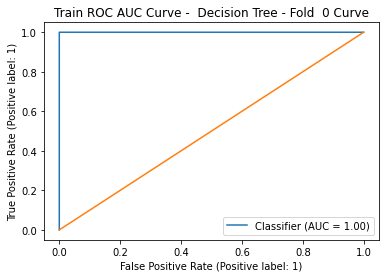

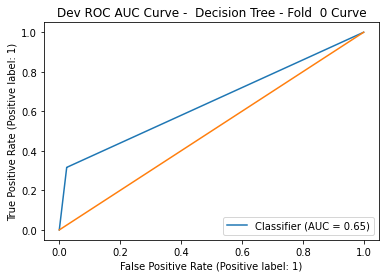

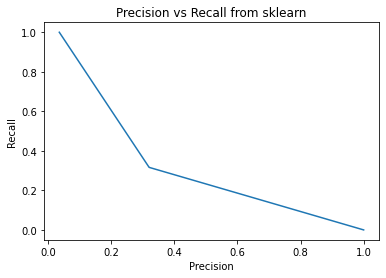

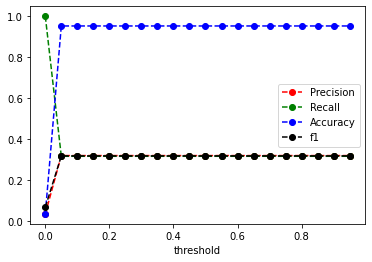

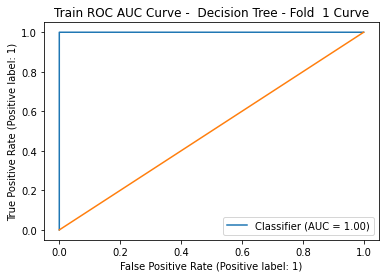

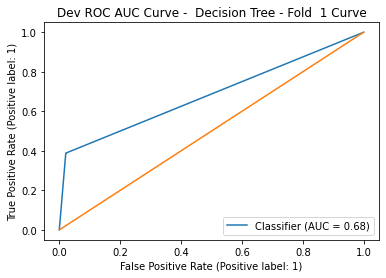

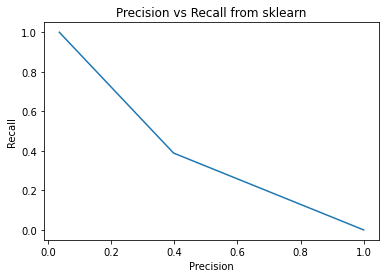

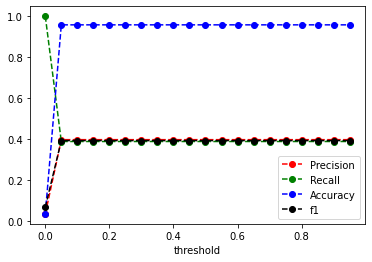

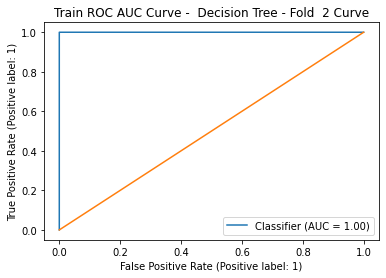

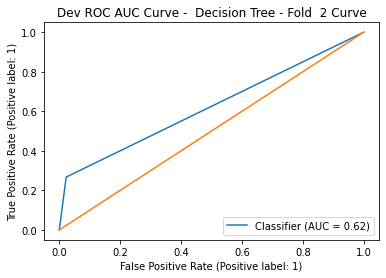

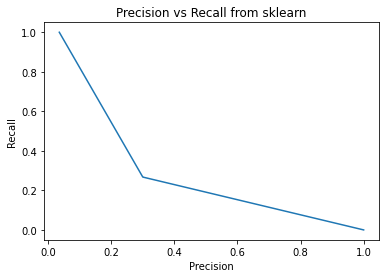

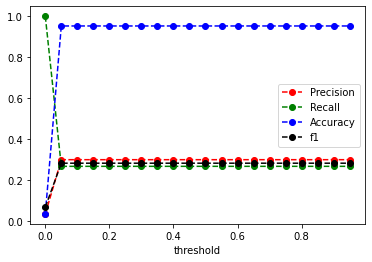

In [20]:
# Generate the model metrics for each of the three folds
DTree_metrics_DF = []
for i_fold in range(0,numFolds): 
  DTree_metrics_DF.append(computeAndPlotMetrics(y_pred_train[i_fold],y_pred_train_prob[i_fold],
                              y_pred_dev[i_fold],y_pred_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'Decision Tree - Fold  ' + str(i_fold) ))

The steep decline in performance from the training to the development dataset indicates severe overfitting.

In Decision Trees, the predict_proba method typically returns either 0 or 1, which is expected behavior. The decision tree calculates the class probability based on the number of samples of each class within a given leaf. By default, parameters controlling the tree's size (such as max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees.

In other words, the tree is expanded until it perfectly fits the training data, resulting in each leaf containing training samples of the same class. Consequently, when a test sample is encountered, it either perfectly matches that class (probability = 1) or does not (probability = 0).

To obtain more refined probability estimates, you can adjust parameters like min_samples_leaf to ensure a minimum number of samples in each leaf. This allows for the computation of probabilities based on a larger sample size, resulting in a broader range of probability estimates (e.g., [0, 0.1, 0.2, ..., 0.9, 1]). Adjusting such parameters can help alleviate overfitting and improve the model's performance on unseen data.

### Hyper-Parameter Tuned Model

In [32]:
y_pred_train = {}
y_pred_dev = {}

y_pred_train_prob = {}
y_pred_dev_prob = {}

y_train_folds = {}
y_dev_folds ={}

for i_fold in range(0,numFolds):
  train_ids = train_dev_indices['train'][i_fold]
  dev_ids  = train_dev_indices['dev'][i_fold]
  
  X_train = X.loc[train_ids,:]
  X_dev = X.loc[dev_ids,:]
  
  y_train = y[train_ids]
  y_dev = y[dev_ids]

  y_train_folds[i_fold] = y_train
  y_dev_folds[i_fold] = y_dev

  y_pred_train[i_fold] = grid.predict(X_train)
  y_pred_dev[i_fold] = grid.predict(X_dev)

  y_pred_train_prob[i_fold] = grid.predict_proba(X_train)[:,1]
  y_pred_dev_prob[i_fold] = grid.predict_proba(X_dev)[:,1]  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

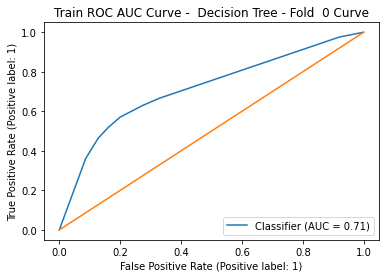

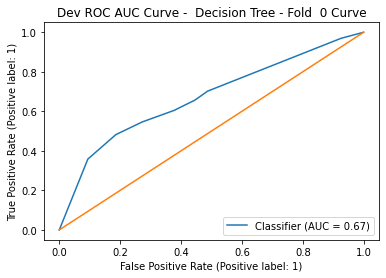

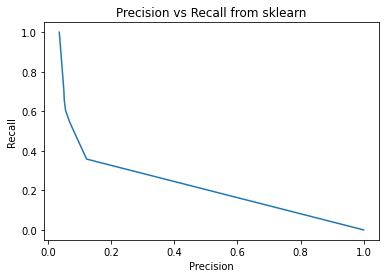

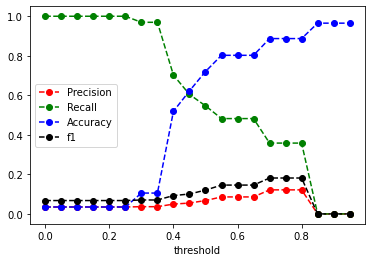

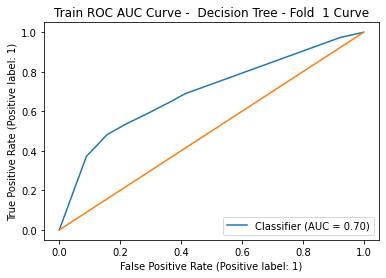

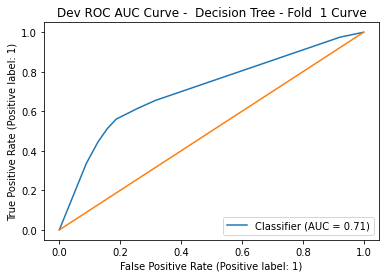

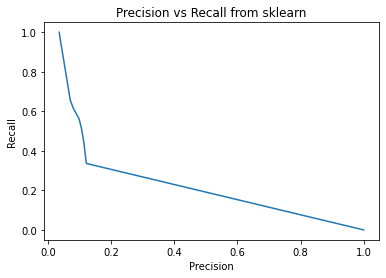

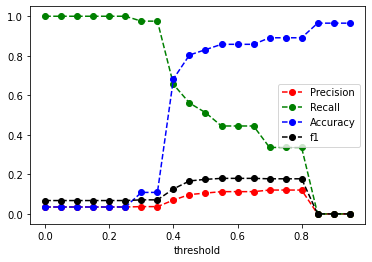

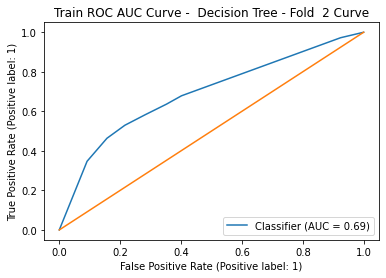

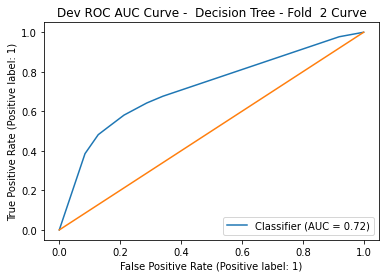

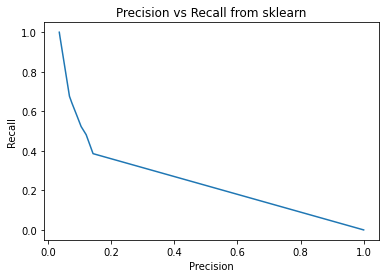

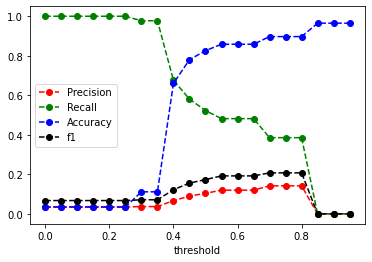

In [33]:
d_tree_metrics_DF_grid = []
thresholds = np.arange(0, 1, .05) 
for i_fold in range(0,numFolds): 
  d_tree_metrics_DF_grid.append(computeAndPlotMetrics(y_pred_train[i_fold],y_pred_train_prob[i_fold],
                              y_pred_dev[i_fold],y_pred_dev_prob[i_fold],
                                  y_dev_folds[i_fold],y_train_folds[i_fold],thresholds,
                                  'Decision Tree - Fold  ' + str(i_fold) ))

## Summary

In [21]:
DTree_metrics_DF

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.999980  0.999710    0.99942  1.000000       1.000000
 1  development  0.952537  0.318079    0.31983  0.316347       0.645979,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.999987  0.999819   0.999637  1.000000        1.00000
 1  development  0.957998  0.392952   0.397504  0.388502        0.68358,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.999992  0.999891   0.999782  1.000000        1.00000
 1  development  0.952516  0.282600   0.299739  0.267315        0.62234]

In [36]:
d_tree_metrics_DF_grid

[  Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.828338  0.174279   0.104773  0.517750       0.714416
 1  development  0.720341  0.120354   0.067619  0.546748       0.671248,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.773113  0.141627   0.081618  0.534955       0.695317
 1  development  0.830792  0.174850   0.105413  0.512340       0.709784,
   Dataset Type  accuracy  f1 score  precision    recall  roc auc score
 0     training  0.775567  0.141722   0.081808  0.529544       0.689932
 1  development  0.825884  0.173722   0.104154  0.523160       0.719149]

The basic decision tree model initially demonstrated perfect accuracy, likely due to overfitting, as it continued expanding until it perfectly fit the training data. After tuning the parameters to address overfitting, the model's performance improved, with a ROC-AUC score of approximately 70 and a recall score of around 0.54. However, this improvement came at the cost of decreased precision and accuracy, as the model began predicting more false positives.

To further enhance the model's performance, the next steps would involve exploring ensemble methods such as Random Forests and Gradient Boosted Trees. These techniques can mitigate overfitting and improve generalization by combining multiple decision trees, thereby offering a more robust and accurate prediction. By leveraging the strength of ensemble methods, we aim to achieve higher predictive accuracy while maintaining a balanced trade-off between precision and recall.